Best covariance type for GMM determined: diag
Minimum number of clusters based on BIC: 1


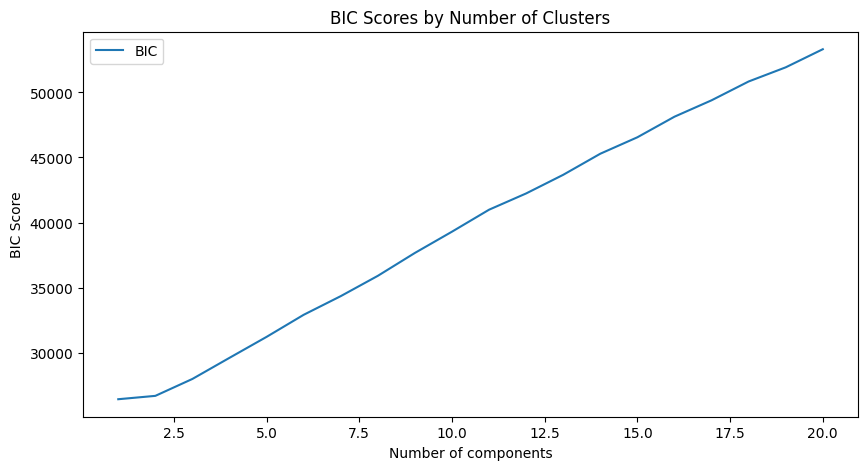

Hard clustering assignments: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Soft clustering probabilities for a few instances:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
Generating new faces and visualize...


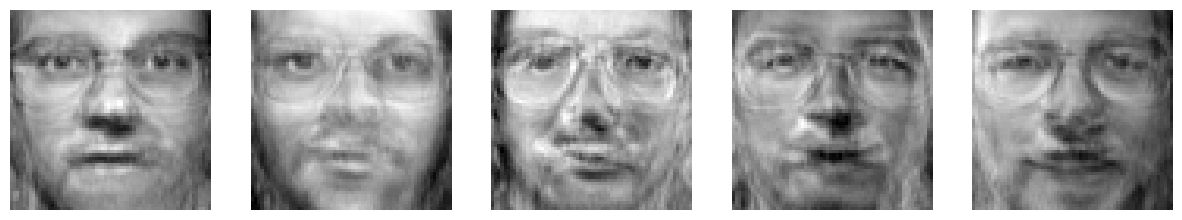

Detecting anomalies...
Normal scores mean: -50.98767816366756, Anomaly score: -5720614.276553627


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from PIL import Image

# Step 1: Load the Olivetti faces dataset
data = fetch_olivetti_faces()
faces = data.images
target = data.target

# Step 2: Stratified split of the dataset
X_train, X_temp, y_train, y_temp = train_test_split(faces.reshape((len(faces), -1)), target, test_size=0.4, random_state=42, stratify=target)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Step 3: Apply PCA preserving 99% of the variance
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train)

# Step 4: Determine the most suitable covariance type for GMM
covariance_types = ['spherical', 'diag', 'tied', 'full']
best_gmm = GridSearchCV(GaussianMixture(random_state=42), {'covariance_type': covariance_types}, cv=3).fit(X_train_pca)
covariance_type = best_gmm.best_params_['covariance_type']
print(f"Best covariance type for GMM determined: {covariance_type}")

# Step 5: Determine the minimum number of clusters using BIC
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type=covariance_type, random_state=42).fit(X_train_pca) for n in n_components]
bic_scores = [m.bic(X_train_pca) for m in models]
best_n_components = n_components[np.argmin(bic_scores)]
print(f"Minimum number of clusters based on BIC: {best_n_components}")

# Step 6: Plot BIC scores
plt.figure(figsize=(10, 5))
plt.plot(n_components, bic_scores, label='BIC')
plt.xlabel('Number of components')
plt.ylabel('BIC Score')
plt.legend()
plt.title('BIC Scores by Number of Clusters')
plt.show()

# Step 7: Output hard clustering assignments
best_gmm = GaussianMixture(n_components=best_n_components, covariance_type=covariance_type, random_state=42).fit(X_train_pca)
hard_clusters = best_gmm.predict(X_train_pca)
print(f"Hard clustering assignments: {hard_clusters}")

# Step 8: Output soft clustering probabilities
soft_clusters = best_gmm.predict_proba(X_train_pca)
print("Soft clustering probabilities for a few instances:")
print(soft_clusters[:5])  # Print probabilities for the first 5 instances for brevity

# Step 9: Generate new faces
print("Generating new faces and visualize...")
new_faces_pca = best_gmm.sample(5)[0]
new_faces = pca.inverse_transform(new_faces_pca)
new_faces_images = new_faces.reshape(-1, 64, 64)  # Reshape them to the original image shape

# Visualize the generated faces
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i, face in enumerate(new_faces_images):
    ax[i].imshow(face, cmap='gray')
    ax[i].axis('off')
plt.show()

# Step 10: Modify an image
example_face = Image.fromarray((new_faces_images[0] * 255).astype('uint8'))
darker_face = Image.eval(example_face, lambda x: x * 0.5)
rotated_face = darker_face.rotate(90)
rotated_face.show()

# Step 11: Detect anomalies
print("Detecting anomalies...")
normal_scores = best_gmm.score_samples(X_train_pca)
anomaly_scores = best_gmm.score_samples(pca.transform(np.array(rotated_face).reshape(1, -1)))
print(f"Normal scores mean: {np.mean(normal_scores)}, Anomaly score: {anomaly_scores[0]}")
